# Generative Model (Coffees dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


In [3]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

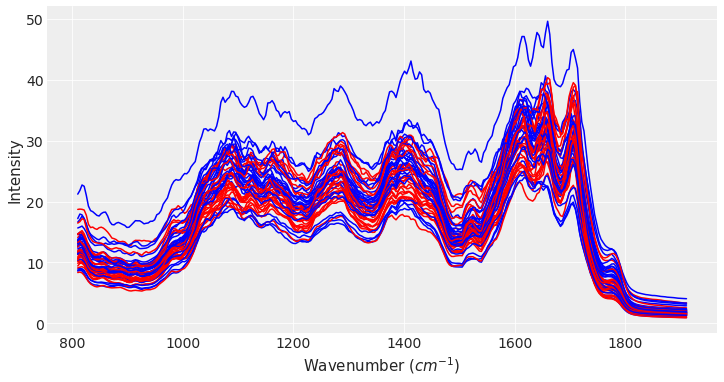

In [4]:
# number of non-data columns at right of dataframe
ndata_cols = -2

# class labels
clabels = ['Arabica', 'Robusta']

# number of classes in data
nclass = len(clabels)

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(50):
    y_val = data.values[i]
    if y_val[-1] == clabels[0]:
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [5]:
#data.describe()

In [6]:
# number of samples from each class
data['label'].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [7]:
# store data values for class A and B
df_a = data.query("label ==  @clabels[0]")
df_b = data.query("label ==  @clabels[1]")

x_n = data.columns[:ndata_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [8]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(nclass,len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa)
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb)

    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
100%|██████████| 2500/2500 [01:11<00:00, 35.10it/s] 


In [9]:
#pm.model_to_graphviz(model_gm)

In [10]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",13.068,0.610,11.900,14.163,0.008,0.006,6084.0,6017.0,6081.0,2484.0,1.0
"mu[0,1]",13.346,0.611,12.217,14.481,0.008,0.006,5405.0,5405.0,5471.0,2991.0,1.0
"mu[0,2]",13.401,0.616,12.241,14.542,0.008,0.006,5391.0,5342.0,5189.0,2722.0,1.0
"mu[0,3]",12.944,0.602,11.717,13.984,0.007,0.005,7601.0,7601.0,7600.0,2832.0,1.0
"mu[0,4]",12.197,0.612,11.121,13.420,0.009,0.006,4962.0,4944.0,4957.0,2869.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,17.216,0.344,16.610,17.907,0.004,0.003,7324.0,7324.0,7325.0,2459.0,1.0
sigma_ab,4.350,1.289,2.440,6.851,0.018,0.014,5394.0,4067.0,7195.0,2804.0,1.0
sigma_mu,8.148,0.234,7.729,8.599,0.003,0.002,6746.0,6738.0,6746.0,3116.0,1.0
sigma_s,2.539,1.049,0.986,4.464,0.017,0.014,3619.0,2775.0,5386.0,2537.0,1.0


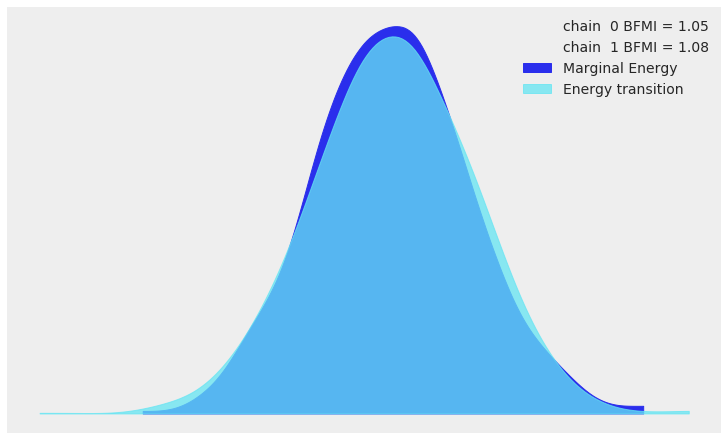

In [11]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [12]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:01<00:00, 186.26it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


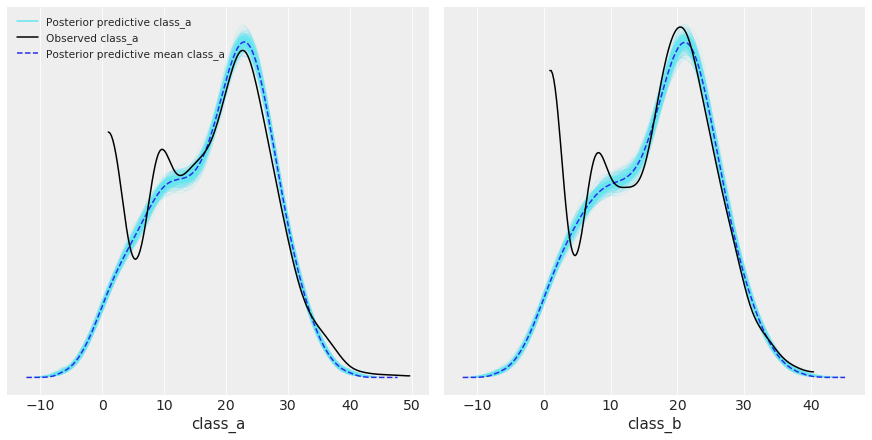

In [13]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [14]:
print(az.r2_score(x_sa, ppc['class_a']))

r2        0.860779
r2_std    0.010652
dtype: float64


In [15]:
print(az.r2_score(x_sb, ppc['class_b']))

r2        0.848763
r2_std    0.011399
dtype: float64


In [16]:
print(az.bfmi(trace_gm))

[1.05136952 1.07807347]


# Posterior samples vs. mean data

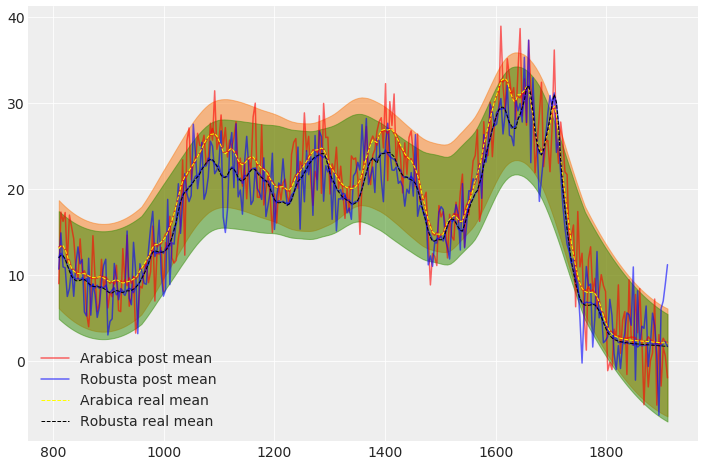

In [17]:
# draw class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']

# get header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(1):
    plt.plot(x_val, cl_a[i,0,:], '-', color="red", alpha=.6)
    plt.plot(x_val, cl_b[i,0,:], '-', color="blue", alpha=.6)

# plot the posterior mean
plt.plot(x_val, cl_a[:,0].mean(axis=0), '-', color="red", alpha=.6, 
         label='Arabica post mean')
plt.plot(x_val, cl_b[:,0].mean(axis=0), '-', color="blue", alpha=.6, 
         label='Robusta post mean')

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]]
df2 = data.loc[data['label'] == clabels[1]]

plt.plot(x_val, df1.iloc[:,:ndata_cols].mean(), '--', color='yellow', 
         label='Arabica real mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:ndata_cols].mean(), '--', color='black', 
         label='Robusta real mean', linewidth=1)
    
# plot 95% HPD interval
az.plot_hpd(x_val, ppc['class_a'], color='C1')
az.plot_hpd(x_val, ppc['class_b'], color='C2')

plt.legend(loc='best');

# Real spectrum vs. posterior samples

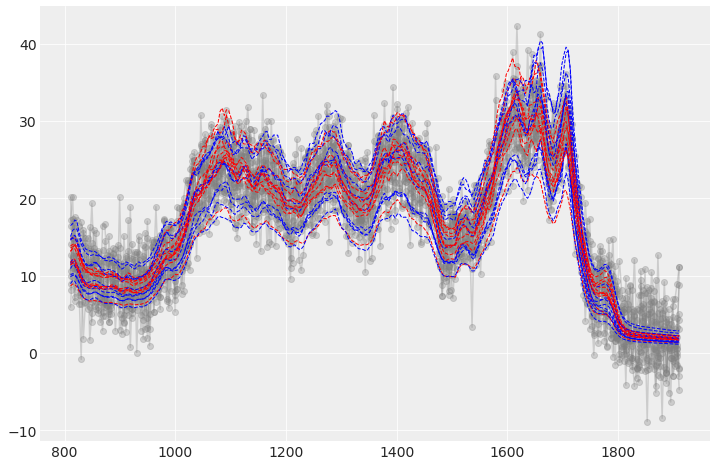

In [18]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(5):
    plt.plot(x_val, cl_a[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_b[i,0,:], 'o-', color="gray", alpha=.3)

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]].sample(frac=1)
df2 = data.loc[data['label'] == clabels[1]].sample(frac=1)
    
for i in range(10):
    plt.plot(x_val, df1.values[i,:ndata_cols], '--', color='red', linewidth=1)
    plt.plot(x_val, df2.values[i,:ndata_cols], '--', color='blue', linewidth=1)

# Save posterior samples to .csv file

In [19]:
import csv

samples_per_class = 100
filename = './ppc_samples_coffees.csv' 

# create header row
header = np.array(np.around(x_val, 3), dtype='str')
header = header.tolist()
header.append("label")

with open(filename, mode='w') as fp:
    ppc_writer = csv.writer(fp, delimiter=',')
    ppc_writer.writerow(header)
    
    for i in range(samples_per_class):
        row_a = np.array(cl_a[i,0,:], dtype='str').tolist()
        row_a.append(clabels[0])
        row_b = np.array(cl_b[i,0,:], dtype='str').tolist()
        row_b.append(clabels[1])
        ppc_writer.writerow(row_a)
        ppc_writer.writerow(row_b)